## 5. Modelling and generating template libraries for smaller regions withing a FOV using the GALACTICNUCLEUS catalogue


In Notebook 2, it was shown the it is not fleasible to generate libraries for different stellar populations for the entire FOV (here we are refering to 1.2' as the FOV) and the entire catalogue has over two hundred thousand stars. The aim of this notebook is to see if we can narrow down this problem by further dividing the FOV into sub-grids and fixing the scale of the problem. 

The notebook is divided into the following sections:
1. Defining Input Parameters
2. Understanding the neighbouring population of stars for the concerned FOV
3. Generation of the template library


Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Nadine Neumayer and Francisco Nogueras-Lara (MPIA)** <br/>
Date: **09th November 2020** <br/>

In [1]:
import astropy.units as u
import astropy.io.fits as fits

import math
from scipy.sparse import csr_matrix
import scipy.stats as stats
import numpy as np
import os
import importlib

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# to show progress during computations
from time import sleep
import sys

import matplotlib
import seaborn as sns

# for doing combinatorics with spectra
from itertools import permutations
from more_itertools import distinct_permutations

In [2]:
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import Simulating_Spectra as ss
import plotting as pt
import Slitless_spec_forward_modelling as ssfm
import star_by_star_template_library as stl
import Fitting_and_pdfs as fap

#### 1. Defining Input Parameters

In [4]:
# FOV in pixels
l_pix, u_pix = 0, 1128

x_pos, y_pos, mag_H, mag_Ks = np.load('Data/selected_FOV.npy')
selected_c_pxls = np.load('Data/selected_central_pixels.npy')
num_stars = len(mag_Ks)

template_dir = 'Data/Template_library/'
hot_stars = 0.1

# set the dispersion range of the spectra
disperse_range = ss.defineDispersionRange(r=4000, lambda0=2.2, band_width=0.4)
print('The size of dispersion is set to be %d pixels'%disperse_range)

dispersion_angle = 0 # degrees

# width of influence of the PSF on neighbouring stars (pixels)
width=3

# number to which the dimensions of the original image is reduced to cal chi-squared
num_splits = int(u_pix/5)

# different populations of hot stars considered 
hot_stars_arr = np.arange(0, 11)/10

# Load the 10 random spectra with added LSF, which can be associated with the stars in the FOV.
flux_LSF2D, params = np.load('Data/flux_K2D_LSF_norm.npy'), np.load('Data/params.npy')
waves_k = np.load('Data/waves_k.npy')

# would you like to discard foreground stars completely or do something more complicated
discard_forground_stars = True
foreground_cutoff = 1.1

# start pixels of a small region of the sky
x_start, y_start = 1000, 2500

The size of dispersion is set to be 727 pixels


Discarding all the forground stars...
Now for the whole central catalog: 
Discarding all the forground stars...


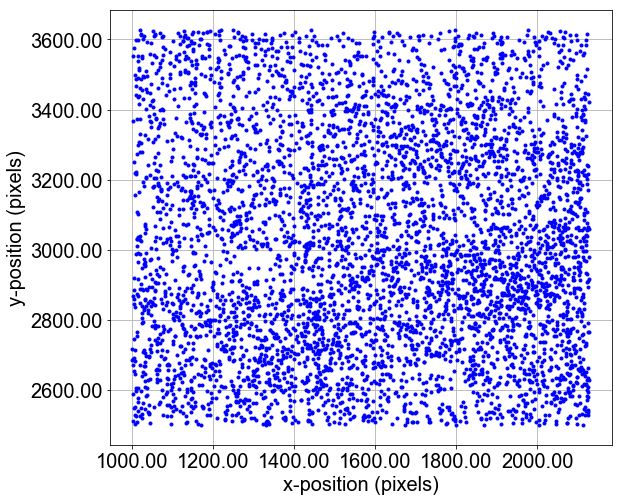

In [5]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

if discard_forground_stars:
    x_pos, y_pos, mag_H, mag_Ks = ssfm.discardForegroundStars(x_pos, y_pos, mag_H, mag_Ks, foreground_cutoff)
    print('Now for the whole central catalog: ')
    selected_c_pxls = ssfm.discardForegroundStars(selected_c_pxls[0], selected_c_pxls[1], selected_c_pxls[2], selected_c_pxls[3], foreground_cutoff)
    
# plotting the stars in the defined FOV
ax.plot(x_pos, y_pos, "b.")
pt.setLabel(ax, 'x-position (pixels)', 'y-position (pixels)', '', 'default',\
            'default', legend=False)

pt.shortenXYaxisTicks(ax)

#### 2. Understanding the neighbouring population of stars for the concerned FOV

In [6]:
importlib.reload(stl)
# these arrays that hold information about the location and number of neighbours
star_neighbours, num_neighbours = stl.findStarAndNeighbours(x_pos, y_pos, mag_H,\
                                                            mag_Ks, disperse_range,\
                                                            width, selected_c_pxls,\
                                                           [x_start, y_start], u_pix)

# arrays extract information about the no. of neighbours in total & outside FOV
neighbours_outside_FOV = np.array(num_neighbours[1])-np.array(num_neighbours[0])
total_neighbours = np.array(num_neighbours[1])

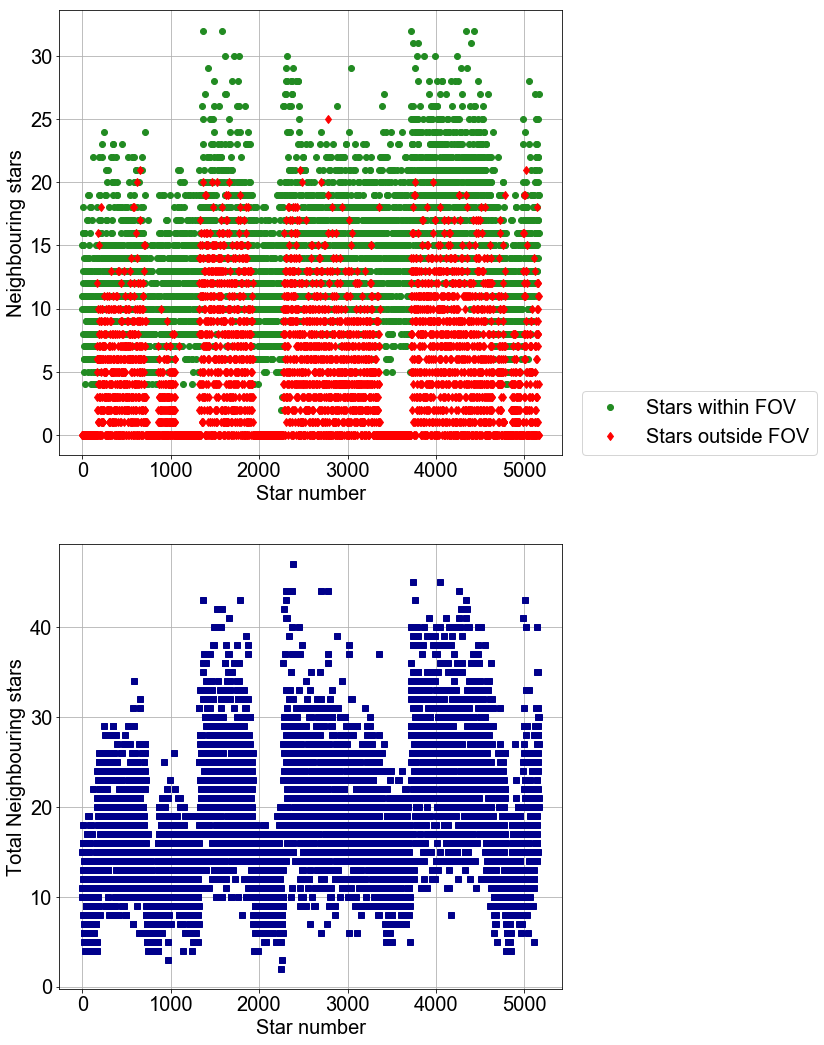

In [7]:
pt.plotAllNeighbours(x_pos, num_neighbours, neighbours_outside_FOV, total_neighbours)

Histrogram shows the distribution of neighbours for each star within the FOV.

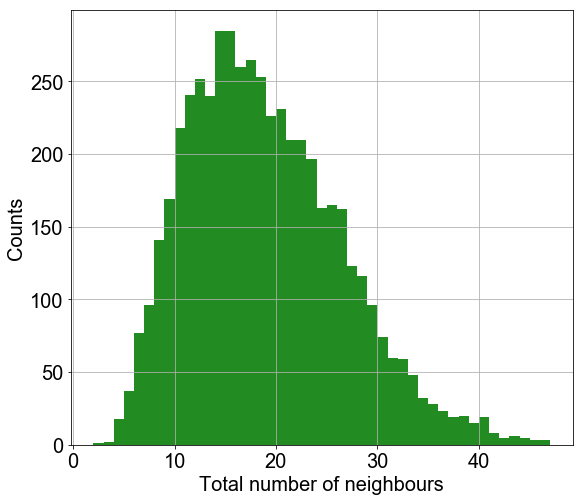

In [8]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

counts, _, _ = ax.hist(total_neighbours, bins=np.unique(total_neighbours), color='ForestGreen')
pt.setLabel(ax, 'Total number of neighbours', 'Counts', '', 'default', 'default', legend=False)

Number of neighbouring stars in FOV: 10
Number of neighbouring stars in effective FOV: 10


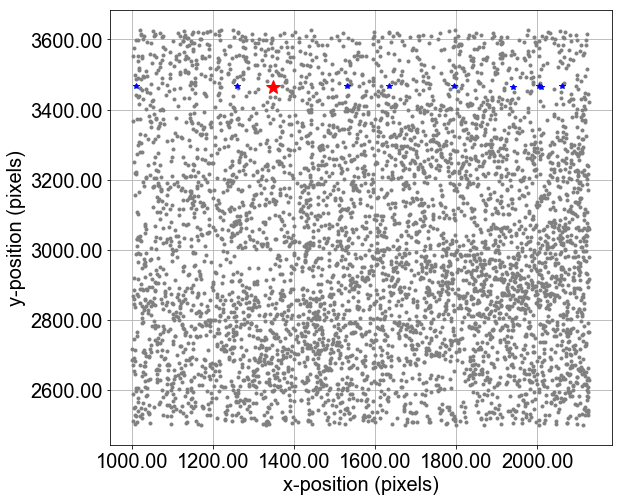

In [14]:
# random index to plot the star and it's associated neighbours
importlib.reload(pt)
idx = 0
pt.visualizingNeighbours(idx, x_pos, y_pos, star_neighbours)

#### 3. Generate template libraries based on number of neighbours for each star (<mark>ran on Queenbee cluster</mark>)

This code block was run on the queenbee computer cluster. An example code block here is shown for the 11 stars case, for 10% and 20% hot stars only. These variables can be adjusted as per preference in the loop.

In [54]:
num_stars_arr = np.sort(np.unique(total_neighbours))

for num_stars in [11]:
    for hot_stars in hot_stars_arr:
        print('\nGenerating templates for %d stars of which there exist %d hot stars...'%(num_stars, num_stars*hot_stars))
    
        # define the division of stars in the chosen FOV (hot or cold)
        stars_divide = ssfm.decideNumHotStars(hot_stars = hot_stars)

        flux_k2D, type_id = ssfm.associateSpectraToStars(waves_k, stars_divide, \
                                                         num_stars, flux_LSF2D, \
                                                         params, print_msg=False)
        # generate and save the templates
        stl.generateSaveTemplates(type_id, flux_LSF2D, flux_k2D, template_dir, num_stars, hot_stars)         


Generating templates for 11 stars of which there exist 0 hot stars...

Generating templates for 11 stars of which there exist 1 hot stars...

Generating templates for 11 stars of which there exist 2 hot stars...

Generating templates for 11 stars of which there exist 3 hot stars...

Generating templates for 11 stars of which there exist 4 hot stars...

Generating templates for 11 stars of which there exist 5 hot stars...

Generating templates for 11 stars of which there exist 6 hot stars...

Generating templates for 11 stars of which there exist 7 hot stars...

Generating templates for 11 stars of which there exist 8 hot stars...

Generating templates for 11 stars of which there exist 9 hot stars...

Generating templates for 11 stars of which there exist 11 hot stars...


#### 4.  Generate a data image that distributes hot and cold stars randomly

Around 8786 stars form neighbours, of which most are repeats. In total, 94993 stars need to be modelled.


/home/shreeram/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


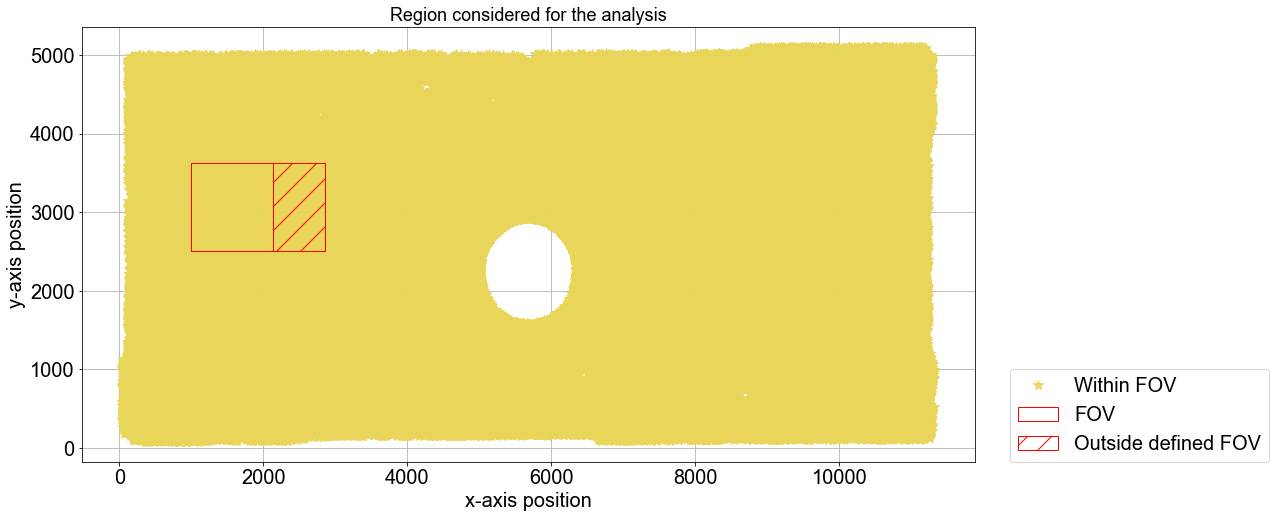

In [16]:
total_stars_FOV_params = stl.starsOutsideFOV(star_neighbours, x_pos, y_pos, mag_H, mag_Ks,\
                               foreground_cutoff, [x_start, y_start], u_pix, selected_c_pxls)

pt.showTheRegionOfAnalysis(selected_c_pxls, total_stars_FOV_params, x_start, y_start, u_pix)

np.save('Data/Many_star_model/stars_outside_FoV_%dx%d.npy'%(x_start, y_start), total_stars_FOV_params)

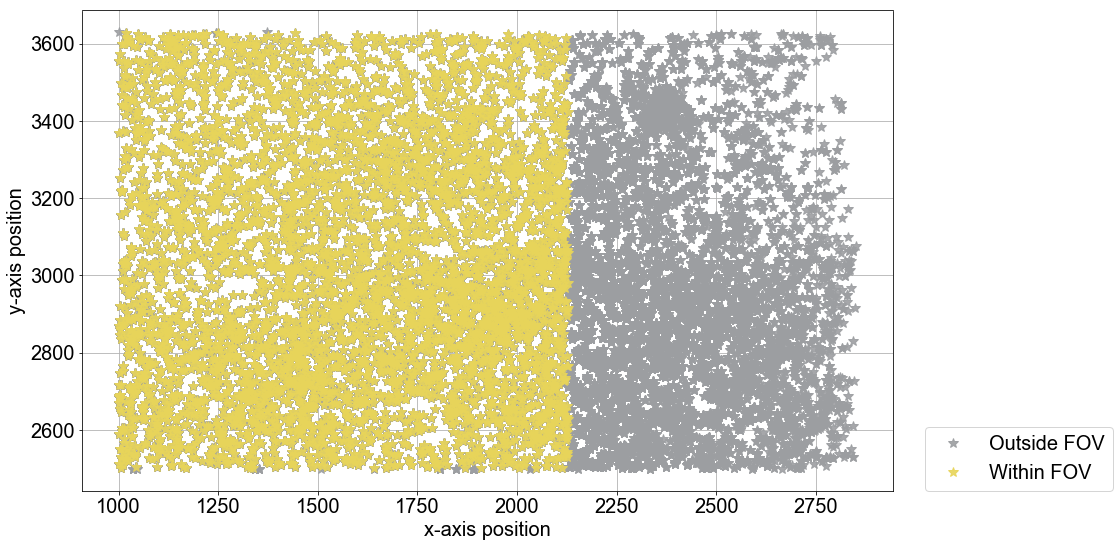

In [17]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

# plotting the stars outside the FOV
ax.plot(total_stars_FOV_params[2], total_stars_FOV_params[3], ".", color= '#9c9ea1', alpha=0.9, marker="*", markersize=10, label='Outside FOV')

# plotting the stars within the FOV
ax.plot(x_pos, y_pos, ".", color= '#e8d55a', alpha=0.9, marker="*", markersize=10, label='Within FOV')

pt.setLabel(ax, 'x-axis position', 'y-axis position', '', 'default', \
                'default', legend=True)

fig.tight_layout()

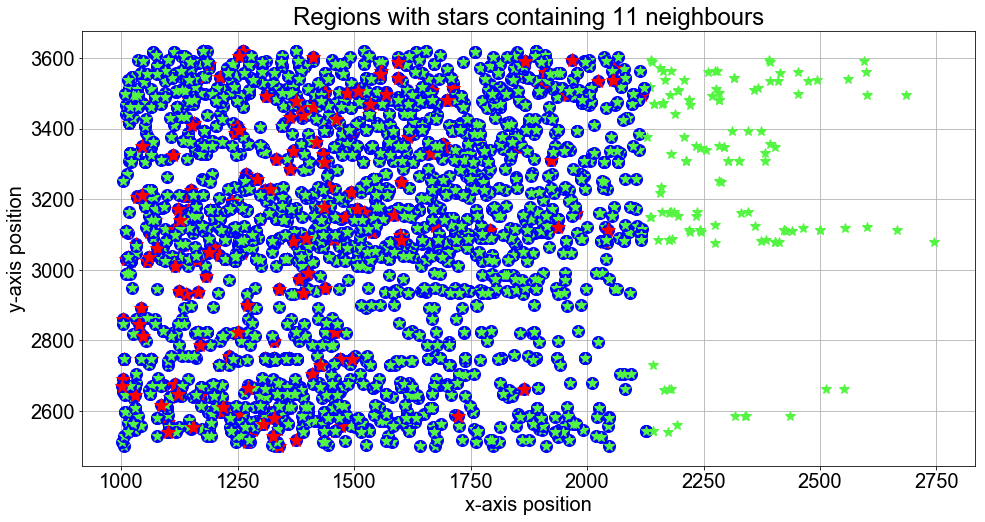

In [35]:
# model all regions with x neighbouring stars
n_stars = 11

# associate spectra to those stars
stars_with_n_neighbours = np.where(total_neighbours == n_stars)

# plot the star under concern and its neighbours
pt.plotAllStarsWithNneighbours(star_neighbours, x_pos, y_pos, stars_with_n_neighbours)

In [36]:
# function to define the effective FOV dimensions
u_pix_arr = stl.defineEffectiveFoV(total_stars_FOV_params, x_start, u_pix)

Function to obtain the x-y dispersion positions of the stars in the FOV. Note that the x-y dispersed matricies have repetitions due to the neighbours of the concerned stars being repeated. However, this is not of concern, expect while creating the data image, since we are using the nearest neighbour approach.

In [ ]:
x_disperse, y_disperse = stl.dispersionWithNstars(total_stars_FOV_params, u_pix_arr, waves_k, \
                                                       disperse_range, dispersion_angle, create_dispersed_files=True)

Now that we know the distribution of hot stars, we generate the desired data matrix or image.

#### 5. Doing the fitting procedure

In [89]:
data_LSF_3Dmat = np.zeros((0, u_pix_arr[1], u_pix_arr[0]))
perm_nos_arr = []

importlib.reload(fap)
importlib.reload(ssfm)
importlib.reload(ss)

for idx, stars in enumerate(stars_with_n_neighbours[0][0:10]):
    x, y, mKs = star_neighbours[1][stars][0], star_neighbours[1][stars][1], star_neighbours[1][stars][3]
    
    # load the data matrix 
    data_LSF_2Dmat, perm_no = fap.dataMatrixNStarsCase(hot_stars, n_stars, u_pix_arr, x, y, mKs, disperse_range, dispersion_angle)
    
    data_LSF_3Dmat = np.append(data_LSF_3Dmat, [data_LSF_2Dmat], axis=0)
    perm_nos_arr.append(perm_no)    

False
False
False
False
False
False
False
False
False
False


In [58]:
data_mat2D = flux_k2D(u_pix_arr[0], u_pix_arr[1]))
for j in range(len(stars_with_n_neighbours[0])):
    data_mat2D = data_mat2D + data_LSF_3Dmat[j]

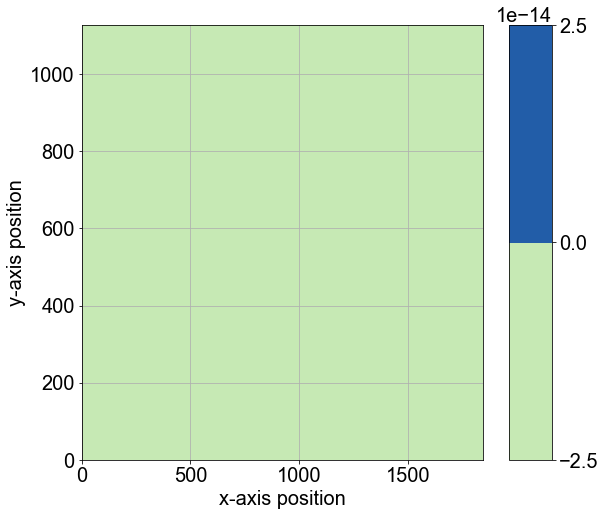

In [78]:
importlib.reload(pt)
pt.plotContour(u_pix_arr, data_LSF_3Dmat[0])

In [91]:
perm_nos_arr

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [84]:
np.any(data_LSF_2Dmat == 0)

True